In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Add,Subtract, Conv1D, Flatten, BatchNormalization, concatenate, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Reshape, Conv1DTranspose, LeakyReLU, Dropout, MaxPooling1D,Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import io, signal
%matplotlib inline
import numpy as np
import os


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt, find_peaks, savgol_filter
import scipy
import math

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def cal_rms(amp):
    return np.sqrt(np.mean(np.square(amp), axis=-1))


In [ ]:
# mix=np.load('Allsub_mix_train.npy')
fecg=np.load('Allsub_fecg_train_c123.npy')
mecg=np.load('Allsub_mecg_train_c123.npy')
noise1=np.load('Allsub_noise1_train_c123.npy')
noise2=np.load('Allsub_noise2_train_c123.npy')
raecg=np.load('real_aecg.npy')
rmecg=np.load('real_mecg.npy')
rfecg=np.load('real_fecg.npy')
print(rmecg.shape)
mix_noise = fecg+mecg+noise1+noise2
mix =fecg+mecg
raecg=raecg.reshape(33,15000,)
rmecg=rmecg.reshape(33,15000,)
rfecg=rfecg.reshape(33,15000,)
rmix = rmecg+rfecg

new_mix_noise=np.vstack([mix_noise[:,0:15000],raecg])
new_mix=np.vstack([mix[:,0:15000],rmix])
new_mecg=np.vstack([mecg[:,0:15000],rmecg])
new_feg=np.vstack([fecg[:,0:15000],rfecg])

new_feg =butter_bandpass_filter(new_feg, 3,90, 250, 3)
new_mecg =butter_bandpass_filter(new_mecg, 3,90, 250, 3)
new_mix =butter_bandpass_filter(new_mix, 3,90, 250, 3)
new_mix_noise =butter_bandpass_filter(new_mix_noise, 3,90, 250, 3)

# new_mix_noise=raecg
# new_mix=rmix
# new_mecg=rmecg
# new_feg=rfecg


print(new_mix.shape, raecg.shape)

In [ ]:
#training_set

out_len = 1024
sub_num=9
samp_num =1473*10
sam_num=0
x = np.empty((samp_num,out_len,1))
x_noise= np.empty((samp_num,out_len,1))
y = np.empty((samp_num,out_len,2))


for sample in range(0,1473):
    for win_num in range(0,10):
        temp_fecg = new_feg[sample, win_num*out_len:win_num*out_len+out_len]
        temp_mecg = new_mecg[sample, win_num*out_len:win_num*out_len+out_len]
        temp_mix  = new_mix[sample, win_num*out_len:win_num*out_len+out_len]
        temp_mix_noise  = new_mix_noise[sample, win_num*out_len:win_num*out_len+out_len]


        n_fecg = np.array(temp_fecg)
        n_mecg = np.array(temp_mecg)
        n_mixture = np.array(temp_mix)     
        n_mixture_noise = np.array(temp_mix_noise)     

        
        n_fecg = (n_fecg-np.mean(n_mixture_noise))/np.var(n_mixture_noise)
        n_mecg = (n_mecg-np.mean(n_mixture_noise))/np.var(n_mixture_noise)
        n_mixture = (n_mixture-np.mean(n_mixture_noise))/np.var(n_mixture_noise)
        n_mixture_noise = (n_mixture_noise-np.mean(n_mixture_noise))/np.var(n_mixture_noise)      
                        
                        
        n_fecg = n_fecg.reshape(len(n_fecg),1)
        n_mecg = n_mecg.reshape(len(n_mecg),1)
        n_mixture = n_mixture.reshape(len(n_mixture),1)
        n_mixture_noise = n_mixture_noise.reshape(len(n_mixture),1)
        
                      
        gt_sig = np.hstack([n_mecg, n_fecg])
                        
                        
        print(sam_num)
        x[sam_num] = n_mixture
        x_noise[sam_num] = n_mixture_noise
        y[sam_num] = gt_sig
                
        
        sam_num+=1

In [ ]:
print(x.shape)
print(x_noise.shape)
tx = np.vstack([x,x_noise])
ty = np.vstack([y,y])
print(tx.shape,ty.shape)

x_train = x
y_train = y

In [ ]:
from sklearn.model_selection import train_test_split

# Y_fecg_train =y_train[:,:,1]

# x_train = np.abs(x_train)
# y_train = np.abs(y_train)


# shuffle = False

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=False, random_state=30)


print(X_train.shape)
print(Y_train.shape)
smp=1
plt.figure(figsize=(20,20))
plt.subplot(311)
plt.plot(X_test[0,:])
plt.plot(Y_test[0,:,1])
plt.subplot(312)
plt.plot(Y_test[0,:,0])
plt.subplot(313)
plt.plot(Y_test[0,:,1])

In [ ]:
from scipy import sparse
from scipy.sparse import spdiags
from scipy.linalg import toeplitz

data = n_fecg
row = np.zeros((len(n_fecg)))
col = np.zeros((len(n_fecg)))

row[0]=-1
col[0]=-1
col[1]= 2
col[2]=-1

print(col)
D = toeplitz(row,col)
sparse_D = sparse.csr_matrix(D)


idx, idy, val = sparse.find(sparse_D)

full_indices = np.stack([idx, idy], axis=1)


# sparse to dense matrix 




def TVD_Loss(y_true, y_pred):
    D2= tf.sparse.SparseTensor(full_indices,val, dense_shape=[1024, 1024])
    y_true= tf.cast(y_true,tf.float64)
    y_pred= tf.cast(y_pred, tf.float64)
    x_deltas = y_true-y_pred
    L1_loss = tf.sparse.sparse_dense_matmul(y_true,D2) - tf.sparse.sparse_dense_matmul(y_pred,D2)
#     TVD =  tf.nn.l2_loss(x_deltas, name=None) + 0.5*tf.reduce_mean(tf.math.abs(L1_loss))
#     TVD =  (1 / 2) * tf.reduce_sum(tf.square(x_deltas)) + 0.005*tf.reduce_mean(tf.abs(L1_loss))
    TVD = 0.0005*tf.reduce_mean(tf.abs(L1_loss))
    return TVD



def autoencoder2(filter1,filter2, kernel1,kernel2 ):
    inputs = Input(shape=(1024,1))   

    y1 = Conv1D(filters=filter1, kernel_size=kernel1,  padding='same', strides=1)(inputs)
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.01)(y1)
    y1 = Conv1D(filters=filter1, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.01)(y1)
    y1 = Conv1D(filters=filter1, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.01)(y1)
    y1_1 = concatenate([y1,y1_in], axis =2)
    y1_1 = Activation('elu')(y1_1)
    y1to2_1 = AveragePooling1D(pool_size=2)(y1_1)

    
    y1 = Conv1D(filters=filter1*2, kernel_size=kernel1, padding='same', strides=1)(y1to2_1) #512
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*2, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*2, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1_2 = concatenate([y1,y1_in], axis =2)
    y1_2 = Activation('elu')(y1_2)
    y1to2_2 = AveragePooling1D(pool_size=2)(y1_2)
    
    y1 = Conv1D(filters=filter1*3, kernel_size=kernel1, padding='same', strides=1)(y1to2_2) #256
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*3, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*3, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1_3 = concatenate([y1,y1_in], axis =2)
    y1_3 = Activation('elu')(y1_3)
    y1to2_3 = AveragePooling1D(pool_size=2)(y1_3)
    
    y1 = Conv1D(filters=filter1*4, kernel_size=kernel1, padding='same', strides=1)(y1to2_3) #128
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*4, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*4, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1_4 = concatenate([y1,y1_in], axis =2)
    y1_4 = Activation('elu')(y1_4)
    y1to2_4 = AveragePooling1D(pool_size=2)(y1_4)
    
    y1 = Conv1D(filters=filter1*5, kernel_size=kernel1, padding='same', strides=1)(y1to2_4) #64
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*5, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*5, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1_5 = concatenate([y1,y1_in], axis =2)
    y1_5 = Activation('elu')(y1_5)
    y1to2_5 = AveragePooling1D(pool_size=2)(y1_5)
    
    
    y1 = Conv1D(filters=filter1*6, kernel_size=kernel1, padding='same', strides=1)(y1to2_5)   #32
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*6, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*6, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = concatenate([y1,y1_in], axis =2)
    y1 = Activation('elu')(y1)
#     y1 = Conv1DTranspose(filters=filter1*6, kernel_size=kernel1,  padding='same', strides=2)(y1)
#     y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = UpSampling1D(size=2)(y1)
    
    
    skip_l5 =  concatenate([y1,y1_5], axis =2)
    y1 = Conv1D(filters=filter1*5, kernel_size=kernel1,  padding='same', strides=1)(skip_l5)
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*5, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*5, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = concatenate([y1,y1_in], axis =2)
    y1 = Activation('elu')(y1)
#     y1 = Conv1DTranspose(filters=filter1*5, kernel_size=kernel1,  padding='same', strides=2)(y1)
#     y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = UpSampling1D(size=2)(y1)
    
    skip_l4 =  concatenate([y1,y1_4], axis =2)
    y1 = Conv1D(filters=filter1*4, kernel_size=kernel1,  padding='same', strides=1)(skip_l4)
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*4, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*4, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = concatenate([y1,y1_in], axis =2)
    y1 = Activation('elu')(y1)
#     y1 = Conv1DTranspose(filters=filter1*4, kernel_size=kernel1,  padding='same', strides=2)(y1)
#     y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = UpSampling1D(size=2)(y1)
    
    skip_l3 =  concatenate([y1,y1_3], axis =2)
    y1 = Conv1D(filters=filter1*3, kernel_size=kernel1,  padding='same', strides=1)(skip_l3)
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*3, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*3, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = concatenate([y1,y1_in], axis =2)
    y1 = Activation('elu')(y1)
#     y1 = Conv1DTranspose(filters=filter1*3, kernel_size=kernel1,  padding='same', strides=2)(y1)
#     y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = UpSampling1D(size=2)(y1)
    
    skip_l2 =  concatenate([y1,y1_2], axis =2)
    y1 = Conv1D(filters=filter1*2, kernel_size=kernel1,  padding='same', strides=1)(skip_l2)
    y1 = BatchNormalization()(y1) 
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*2, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1*2, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = concatenate([y1,y1_in], axis =2)
    y1 = Activation('elu')(y1)
#     y1 = Conv1DTranspose(filters=filter1*2, kernel_size=kernel1,  padding='same', strides=2)(y1)
#     y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = UpSampling1D(size=2)(y1)
    
    skip_l1 =  concatenate([y1,y1_1], axis =2) 
    y1 = Conv1D(filters=filter1, kernel_size=kernel1,  padding='same', strides=1)(skip_l1)
    y1 = BatchNormalization()(y1)
    y1_in = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1, kernel_size=kernel1,  padding='same', strides=1)(y1_in)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = Conv1D(filters=filter1, kernel_size=kernel1,  padding='same', strides=1)(y1)
    y1 = BatchNormalization()(y1)
    y1 = LeakyReLU(alpha=0.02)(y1)
    y1 = concatenate([y1,y1_in], axis =2)
    y1 = Activation('elu')(y1)
    
    output_layer1 =  Conv1D(1, 1024,  padding='same')(y1)
    
#     mer = inputs-output_layer1
    
    y2 = Conv1D(filters=filter2, kernel_size=kernel2,  padding='same', strides=1)(inputs)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2, kernel_size=kernel2,  padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2_1 = concatenate([y2,y2_in], axis =2)
    y2_1 = Activation('elu')(y2_1)
    y2 = AveragePooling1D(pool_size=2)(y2_1)
    y2 = concatenate([y2, y1to2_1],axis =2)
    y2 = Activation('elu')(y2)
    
    y2 = Conv1D(filters=filter2*2, kernel_size=kernel2, padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*2, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*2, kernel_size=kernel2,  padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2_2 = concatenate([y2,y2_in], axis =2)
    y2_2 = Activation('elu')(y2_2)
    y2 = AveragePooling1D(pool_size=2)(y2_2)
    y2 = concatenate([y2,y1to2_2 ],axis =2)
    y2 = Activation('elu')(y2)
    
    y2 = Conv1D(filters=filter2*3, kernel_size=kernel2, padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*3, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*3, kernel_size=kernel2,  padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2_3 = concatenate([y2,y2_in], axis =2)
    y2_3 = Activation('elu')(y2_3)
    y2 = AveragePooling1D(pool_size=2)(y2_3)
    y2 = concatenate([y2,y1to2_3 ],axis =2)
    y2 = Activation('elu')(y2)
    
    y2 = Conv1D(filters=filter2*4, kernel_size=kernel2, padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*4, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*4, kernel_size=kernel2,  padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2_4 = concatenate([y2,y2_in], axis =2)
    y2_4 = Activation('elu')(y2_4)
    y2 = AveragePooling1D(pool_size=2)(y2_4)
    y2 = concatenate([y2, y1to2_4 ],axis =2)
    y2 = Activation('elu')(y2)
    
    y2 = Conv1D(filters=filter2*5, kernel_size=kernel2, padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*5, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*5, kernel_size=kernel2,  padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2_5 = concatenate([y2,y2_in], axis =2)
    y2_5 = Activation('elu')(y2_5)
    y2 = AveragePooling1D(pool_size=2)(y2_5)
    y2 = concatenate([y2, y1to2_5 ],axis =2)
    y2 = Activation('elu')(y2)
    
    y2 = Conv1D(filters=filter2*5, kernel_size=kernel2, padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*5, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = concatenate([y2,y2_in], axis =2)
    y2 = Activation('elu')(y2)
    y2 = Conv1DTranspose(filters=filter2*5, kernel_size=kernel2,  padding='same', strides=2)(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    
    
    
    skip2_l5 =  concatenate([y2,y2_5], axis =2)
    y2 = Conv1D(filters=filter2*5, kernel_size=kernel2,  padding='same', strides=1)(skip2_l5)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*5, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = concatenate([y2,y2_in], axis =2)
    y2 = Activation('elu')(y2)
    y2 = Conv1DTranspose(filters=filter2*5, kernel_size=kernel2,  padding='same', strides=2)(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    
    
    skip2_l4 =  concatenate([y2,y2_4], axis =2)
    y2 = Conv1D(filters=filter2*4, kernel_size=kernel2,  padding='same', strides=1)(skip2_l4)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*4, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = concatenate([y2,y2_in], axis =2)
    y2 = Activation('elu')(y2)
    y2 = Conv1DTranspose(filters=filter2*4, kernel_size=kernel2,  padding='same', strides=2)(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    
    
    skip2_l3 =  concatenate([y2,y2_3], axis =2)
    y2 = Conv1D(filters=filter2*3, kernel_size=kernel2,  padding='same', strides=1)(skip2_l3)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*3, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = concatenate([y2,y2_in], axis =2)
    y2 = Activation('elu')(y2)
    y2 = Conv1DTranspose(filters=filter2*3, kernel_size=kernel2,  padding='same', strides=2)(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
   
    
    skip2_l2 =  concatenate([y2,y2_2], axis =2)
    y2 = Conv1D(filters=filter2*2, kernel_size=kernel2,  padding='same', strides=1)(skip2_l2)
    y2 = BatchNormalization()(y2) 
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2*2, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = concatenate([y2,y2_in], axis =2)
    y2 = Activation('elu')(y2)
    y2 = Conv1DTranspose(filters=filter2*2, kernel_size=kernel2,  padding='same', strides=2)(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    
    skip2_l1 =  concatenate([y2,y2_1], axis =2)
    y2 = Conv1D(filters=filter2, kernel_size=kernel2,  padding='same', strides=1)(skip2_l1)
    y2 = BatchNormalization()(y2)
    y2_in = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2, kernel_size=kernel2,  padding='same', strides=1)(y2_in)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = Conv1D(filters=filter2, kernel_size=kernel2,  padding='same', strides=1)(y2)
    y2 = BatchNormalization()(y2)
    y2 = LeakyReLU(alpha=0.01)(y2)
    y2 = concatenate([y2,y2_in], axis =2)
    y2 = Activation('elu')(y2)

    merge2= concatenate([y1,y2], axis =2)
    
    output_layer2 =  Conv1D(1, 1024,  padding='same')(y2)
       
    autoencoder = Model(inputs = inputs, outputs = [ output_layer1 ,  output_layer2] )
    
#     autoencoder.summary()
    
    return autoencoder
activation_fun = tf.keras.layers.LeakyReLU(alpha=0.2) 
    
m=autoencoder2(16,16, 5, 7)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# m.compile(loss=[TVD_Loss,'mae'],optimizer=opt)
m.compile(loss=['mae','mae'],optimizer=opt)
m.summary()
m.output

In [ ]:
mecg_train=y_train[:,:,0]
fecg_train=y_train[:,:,1]

# mecg_train=mecg_train.reshape(len(Y_train),1024,1)
# fecg_train=fecg_train.reshape(len(Y_train),1024,1)
# a={"MECG":mecg_train,"FECG":fecg_train}
# print(a)

print(mecg_train.shape)
print(fecg_train.shape)



a=[mecg_train, fecg_train]


m.fit(x_train, a, epochs=10, batch_size=64)
# m.fit(X_train, Y_train, epochs=5, batch_size=64)

In [ ]:
# 3. 모델 사용하기

# test_aecg = interpolated_acg1[0:1024]
# test_fecg = interpolated_fecg1[0:1024]


# c= np.array(BaselineWanderRemoval.fix_baseline_wander(test_aecg, sr=31))

# print(c.shape)



# ref  =butter_bandpass_filter(test_fecg, 3,90, 250, 3)
samp=7
i =1

test_aecg= raecg[samp,:]
test_fecg = rfecg[samp,i*1024:i*1024+1024]
test_mecg = rmecg[samp,i*1024:i*1024+1024]
print(test_aecg.shape)

fecg1=test_aecg[i*1024:i*1024+1024]
fecg = fecg1.reshape(1,1024, 1)




out=m.predict(fecg)
a=out[0][0,:,0]

f_out =butter_bandpass_filter(out[1][0,:,0], 10,45, 250, 3)



# b=test_aecg[0:1024]
# print(a.shape,b.shape)



plt.figure(figsize=(20,20))
plt.subplot(311)
plt.plot(fecg1)
plt.plot(out[1][0,:,0])
# plt.plot(test_mecg)
plt.subplot(312)
plt.plot(out[0][0,:,0])
plt.plot(test_mecg)
plt.subplot(313)
plt.plot(f_out)
# plt.plot(test_fecg)

In [ ]:
from keras.models import load_model

m.save('fetal_ecg_sep.h5')

print("Saved model to disk")

In [2]:
from keras.models import load_model

m=load_model('fetal_ecg_sep.h5')

m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 16)     96          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 16)    64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, 1024, 16)     0           ['batch_normalization[0][0]']

(4, 60000) (167, 1)
[[   74]
 [  161]
 [  248]
 [  336]
 [  424]
 [  512]
 [  600]
 [  688]
 [  777]
 [  866]
 [  954]
 [ 1044]
 [ 1134]
 [ 1224]
 [ 1313]
 [ 1403]
 [ 1493]
 [ 1583]
 [ 1672]
 [ 1763]
 [ 1855]
 [ 1946]
 [ 2038]
 [ 2129]
 [ 2220]
 [ 2312]
 [ 2403]
 [ 2494]
 [ 2584]
 [ 2675]
 [ 2766]
 [ 2856]
 [ 2946]
 [ 3036]
 [ 3125]
 [ 3214]
 [ 3304]
 [ 3394]
 [ 3483]
 [ 3573]
 [ 3662]
 [ 3752]
 [ 3841]
 [ 3931]
 [ 4020]
 [ 4110]
 [ 4200]
 [ 4291]
 [ 4383]
 [ 4474]
 [ 4565]
 [ 4656]
 [ 4748]
 [ 4839]
 [ 4930]
 [ 5021]
 [ 5111]
 [ 5203]
 [ 5293]
 [ 5384]
 [ 5474]
 [ 5564]
 [ 5654]
 [ 5744]
 [ 5835]
 [ 5926]
 [ 6016]
 [ 6106]
 [ 6196]
 [ 6287]
 [ 6377]
 [ 6468]
 [ 6558]
 [ 6650]
 [ 6740]
 [ 6831]
 [ 6921]
 [ 7011]
 [ 7101]
 [ 7190]
 [ 7280]
 [ 7368]
 [ 7457]
 [ 7545]
 [ 7634]
 [ 7721]
 [ 7810]
 [ 7898]
 [ 7986]
 [ 8074]
 [ 8163]
 [ 8251]
 [ 8338]
 [ 8426]
 [ 8513]
 [ 8600]
 [ 8687]
 [ 8774]
 [ 8860]
 [ 8948]
 [ 9034]
 [ 9120]
 [ 9206]
 [ 9292]
 [ 9377]
 [ 9462]
 [ 9548]
 [ 9633]
 [ 9720]

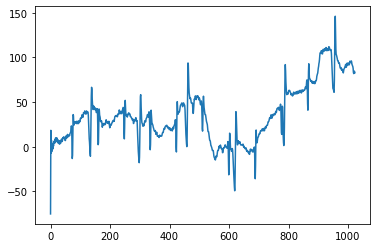

In [12]:
mat_file = io.loadmat('./set-a/a28.mat')




AECG = mat_file['val']
QRS = mat_file['FR']


print(AECG.shape, QRS.shape)

fetal =  AECG[0, :]
aecg1 = AECG[2, :]
QRS=np.round(QRS/4)
QRS=QRS.astype(int)
print(QRS)

even_times = np.arange(0, 60, 1/250)
# interpolated_acg1 = signal.resample(aecg1,len(even_times))
interpolated_fecg1 = signal.resample(fetal,len(even_times))
print(interpolated_fecg1.shape)

plt.plot(interpolated_fecg1[0:1024])


(1024,)
[[-8118]
 [-8031]
 [-7944]
 [-7856]
 [-7768]
 [-7680]
 [-7592]
 [-7504]] [  34  149  236  324  411  492  584  671  758  844  924 1010]


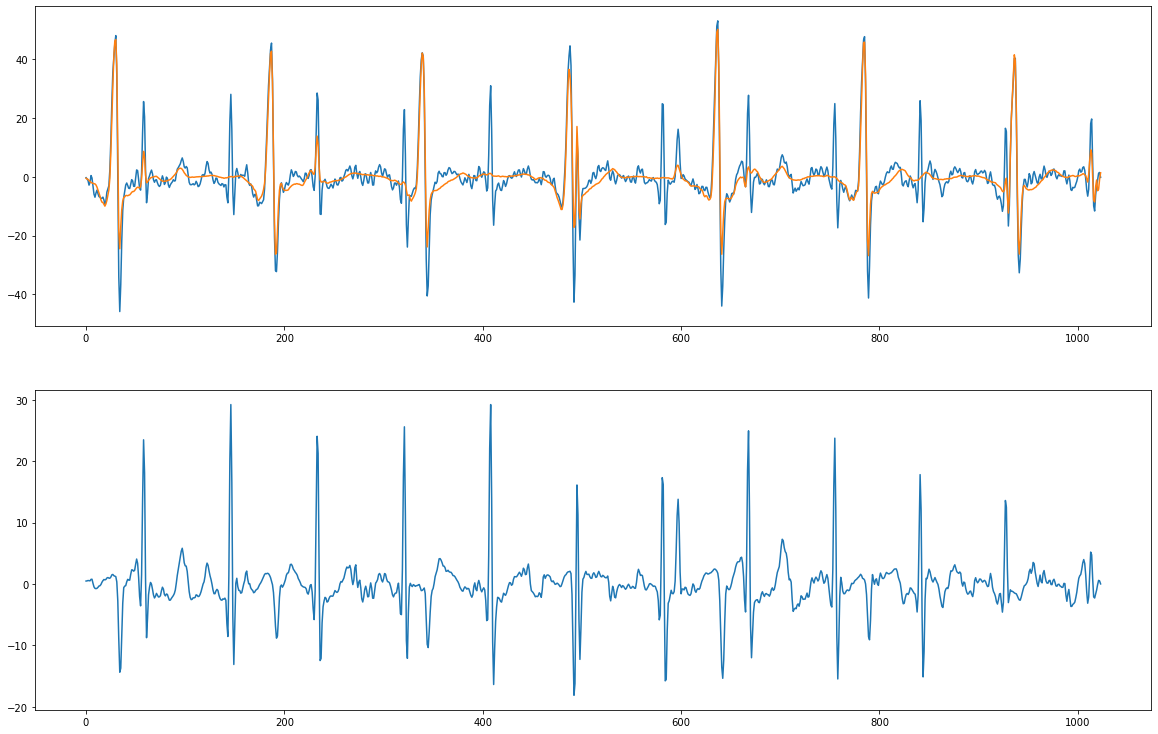

In [28]:
from scipy.signal import find_peaks
from scipy.io import savemat

win_num =8
win_size = 1024


test_fecg = interpolated_fecg1[win_num*win_size:win_num*win_size+win_size]



fecg1 =butter_bandpass_filter(-test_fecg, 5,90, 250, 3)



fecg = fecg1.reshape(1,1024,1)




out=m.predict(fecg)
a=out[0][0,:,0]





print(a.shape)
mecg =out[0][0,:,0]
est =out[1][0,:,0]
peak=QRS[0:8]-1024*win_num

peaks, _ = find_peaks(-est, distance=80)

print(peak,peaks)

plt.figure(figsize=(20,20))
plt.subplot(311)
plt.plot(fecg1)
plt.plot(out[0][0,:,0])
plt.subplot(312)
plt.plot(est)
# plt.plot(peak,est[peak],'x')
# plt.plot(peaks,est[peaks],'o')

# from scipy.io import savemat
mdic = {"aecg": test_fecg,  "mecg": mecg , "fecg": est}

savemat("a28_result.mat", mdic)

In [ ]:
win_size = 1024
fetal =[]
for win_num in range(0,14):
    test_fecg = interpolated_fecg1[win_num*win_size:win_num*win_size+win_size]
    fecg1 =butter_bandpass_filter(test_fecg, 5,90, 250, 3)
    fecg = fecg1.reshape(1,1024,1)
    out=m.predict(fecg)
    
    est =out[1][0,:,0]
    
    fetal.extend(est)
    
fetal=np.array(fetal)
print(fetal.shape, QRS.shape)
plt.plot(fetal)

peaks, _ = find_peaks(-fetal, distance=80)
peaks= peaks.reshape(peaks.shape[0],1)
print(peaks,QRS)


diff = np.zeros(peaks.shape[0])

for i in range(0,peaks.shape[0]):
    diff[i]=peaks[i]-QRS[i]
    
print(diff)


(6, 300000)
(300000,)
(75000,) (75000,)


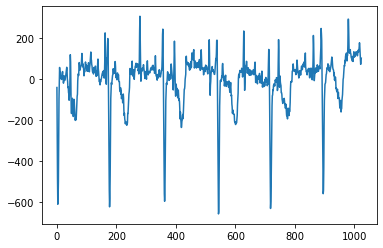

In [46]:
from scipy import io
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

mat_file = io.loadmat('./invasive/r01_edfm.mat')


AECG = mat_file['val']




print(AECG.shape)

di_fecg=AECG[0, :]
aecg1 = AECG[1, :]

print(aecg1.shape)

even_times = np.arange(0, 300, 1/250)
interpolated_acg1 = signal.resample(aecg1,len(even_times))
interpolated_fecg = signal.resample(di_fecg,len(even_times))
print(interpolated_acg1.shape, interpolated_acg1.shape)

plt.plot(interpolated_acg1[0:1024])

(1024,)


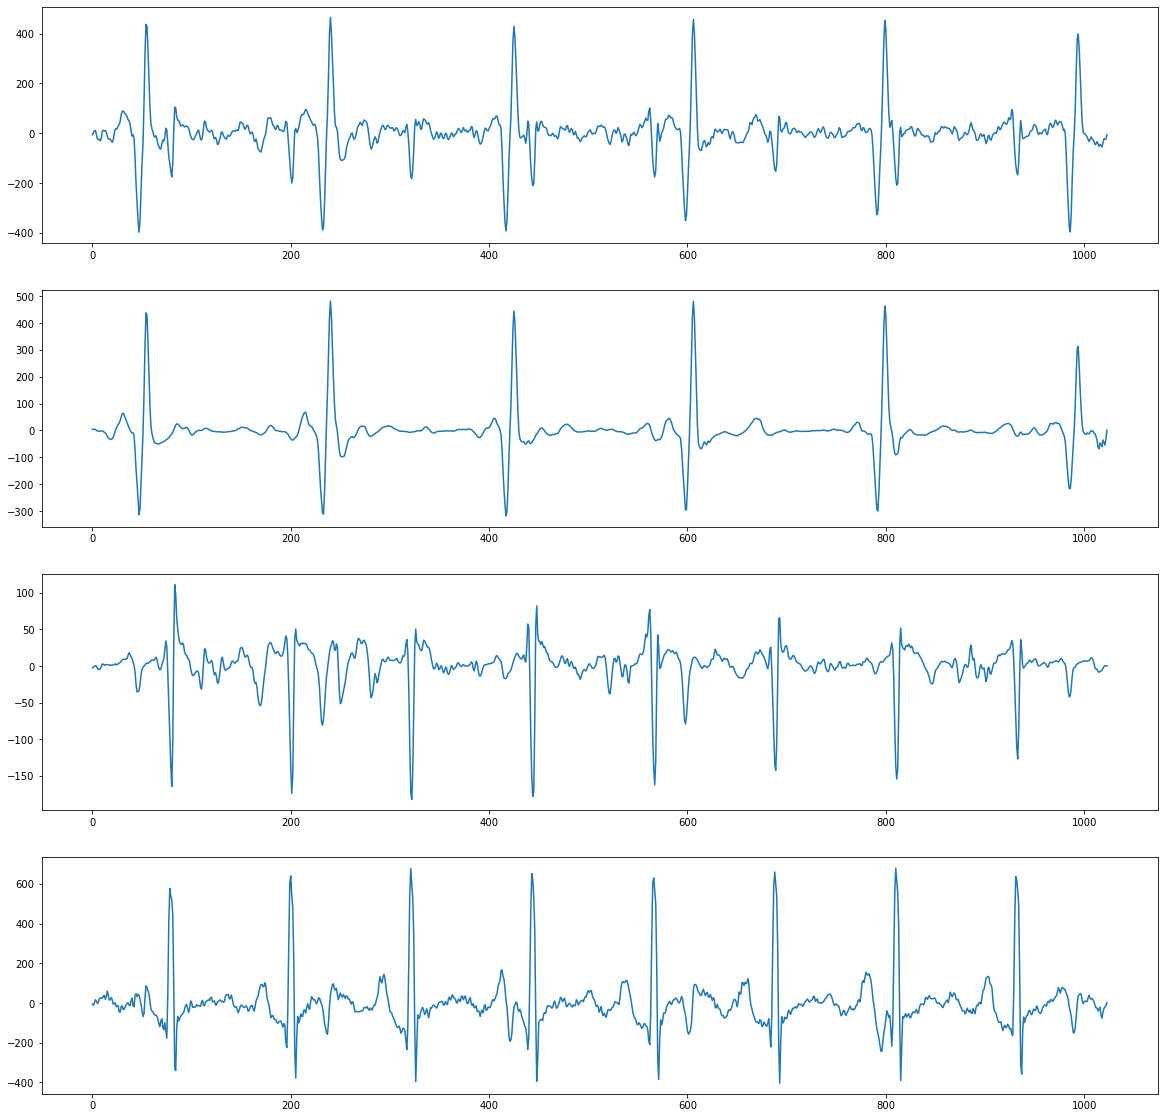

In [44]:
from scipy.io import savemat

win_num =8
win_size = 1024


test_fecg = interpolated_acg1[win_num*win_size:win_num*win_size+win_size]
di_fecg = interpolated_fecg[win_num*win_size:win_num*win_size+win_size]



fecg1 =butter_bandpass_filter(-test_fecg, 5,90, 250, 3)
di_fecg=butter_bandpass_filter(di_fecg, 5,90, 250, 3)



fecg = fecg1.reshape(1,1024,1)




out=m.predict(fecg)
a=out[0][0,:,0]





print(a.shape)
mecg =out[0][0,:,0]
est =out[1][0,:,0]


plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(fecg1)
plt.subplot(412)
plt.plot(mecg)
plt.subplot(413)
plt.plot(est)
plt.subplot(414)
plt.plot(di_fecg)

# from scipy.io import savemat
mdic = {"aecg": fecg1,  "mecg": mecg , "fecg": est, "dfecg": di_fecg }

savemat("r04_result.mat", mdic)
